In [25]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk


In [23]:
from IPython.core.interactiveshell import InteractiveShell
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import nltk


In [26]:
np.random.seed = 0
nltk.download('punkt')
InteractiveShell.ast_node_interactivity = "all"
nltk.download('stopwords')
np.set_printoptions(precision= 3)
pd.set_option("display.max_columns", None)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fourz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fourz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
np.random.seed = 0
np.set_printoptions(precision= 3)
data = "C:/Users/fourz/Downloads/TV_Series.csv"
df = pd.read_csv(data)
df.sample(5)

,Series Title,Release Year,Runtime,Genre,Rating,Cast,Synopsis
42948,The Bear,(2022– ),30 min,"Comedy, Drama",8.4,"Jeremy Allen White, Ebon Moss-Bachrach, Ayo Ed...",A young chef from the fine dining world return...
960,Who's the Boss?,(1984–1992),30 min,"Comedy, Family, Romance",6.6,"Tony Danza, Judith Light, Alyssa Milano, Danny...","Tony Micelli, a retired baseball player, becom..."
36295,Law & Order: Special Victims Unit,(1999– ),60 min,"Crime, Drama, Mystery",8.1,"Mariska Hargitay, Christopher Meloni, Ice-T, D...","This series follows the Special Victims Unit, ..."
46676,Severance,(2022– ),55 min,"Drama, Mystery, Sci-Fi",8.7,"Adam Scott, Zach Cherry, Britt Lower, Tramell ...",Mark leads a team of office workers whose memo...
21211,The Walking Dead,(2010–2022),44 min,"Drama, Horror, Thriller",8.1,"Andrew Lincoln, Norman Reedus, Melissa McBride...",Sheriff Deputy Rick Grimes wakes up from a com...


In [17]:
class Preprocessor:
    
    """
    Класс для предварительной обработки набора данных о телесериалах.

    Аргументы:
        df (pandas.DataFrame): Набор данных, которые требуется предварительно обработать.

    Атрибуты:
        pattern_remove (str): Регулярное выражение.
        df (pandas.DataFrame): Предварительно обработанный набор данных.
        pattern_text (str): Регулярное выражение смайлов.
        stop_words (set): Множество стоп-слов.

    Методы:
        clean_df(self): Очищает набор данных.
        normalization(self): Нормализует набор данных.
        one_hot_df(self): Преобразует столбец с жанрами в формат ONE_hot_encoding.
    """
    
    def __init__(self, df: pd.DataFrame) -> None:
        self.pattern_remove = r"\((\d+)\)"
        self.df = df
        self.pattern_text = '(?::|;|=)(?:-)?(?:\)|\(|D|P)'
        self.stop_words = set(stopwords.words('english'))
    
    def clean_df(self, df: pd.DataFrame) -> pd.DataFrame:
        
         """
        Очищает набор данных.

        Аргументы:
            df (pandas.DataFrame): Набор данных, который требуется очистить.

        Возвращает:
            pandas.DataFrame: Очищенный набор данных.
        """
            
        df.rename(columns=lambda col_: col_.lower().replace(' ', '_'), inplace=True)
    
        df["rating"] = pd.to_numeric(df["rating"].replace("****", np.nan))
    
        df["runtime"] = df["runtime"].replace("****", '').str.extract(r"(\d+) min")
    
        df["end_year"] = df["release_year"].str.extract(r"-?(\d+)\)")
        
        df["release_year"] = df["release_year"].str.extract(r"\((\d+)–?")
    
        df["synopsis"] = df["synopsis"].astype('str')
              
        return df
    
    def normalization(self, df: pd.DataFrame) -> pd.DataFrame:
        
        """
        Нормализует набор данных.

        Аргументы:
            df (pandas.DataFrame): Набор данных, который требуется нормализовать.

        Возвращает:
            pandas.DataFrame: Нормализованный набор данных.
        """
        
        df["synopsis1"] = df["synopsis"].map(lambda x: re.sub('<[^>]*>', '', x))
        df["synopsis1"] = df["synopsis1"].map(lambda x: re.sub(r"[^\w\s_]", '', x.lower()))
        df["synopsis1"] = df["synopsis"].map(lambda x: ' '.join([word for word in x.split() if word not in self.stop_words]))
        df["synopsis1"] = df["synopsis1"].map(lambda x: re.sub(self.pattern_remove, '', x))
    
        return df
    
    def one_hot_df(self, df: pd.DataFrame) -> pd.DataFrame:
        
         """
        Преобразует столбец с жанрами в формат с одним горячим кодированием.

        Аргументы:
            df (pandas.DataFrame): Набор данных, который требуется преобразовать.

        Возвращает:
            pandas.DataFrame: Набор данных с преобразованным столбцом жанров в формат с одним горячим кодированием.
        """
            
        one_hot = pd.get_dummies(df['genre'].str.split(', ', expand=True).stack()).groupby(level=0).sum()
        one_hot = one_hot.add_prefix('genre_')
    
        final_df = df.join(one_hot)
    
        final_df.drop(columns=['genre_****'], inplace=True)
        final_df["synopsis_tokens"] = final_df["synopsis"].apply(word_tokenize)
    
        return  final_df
    
preprocessor = Preprocessor(df)


final_df = (preprocessor.df.pipe(preprocessor.clean_df)
                          .pipe(preprocessor.normalization))


# final_df.to_csv("C:/Users/fourz/OneDrive/Рабочий стол/Word2Vec/filter_data.csv")


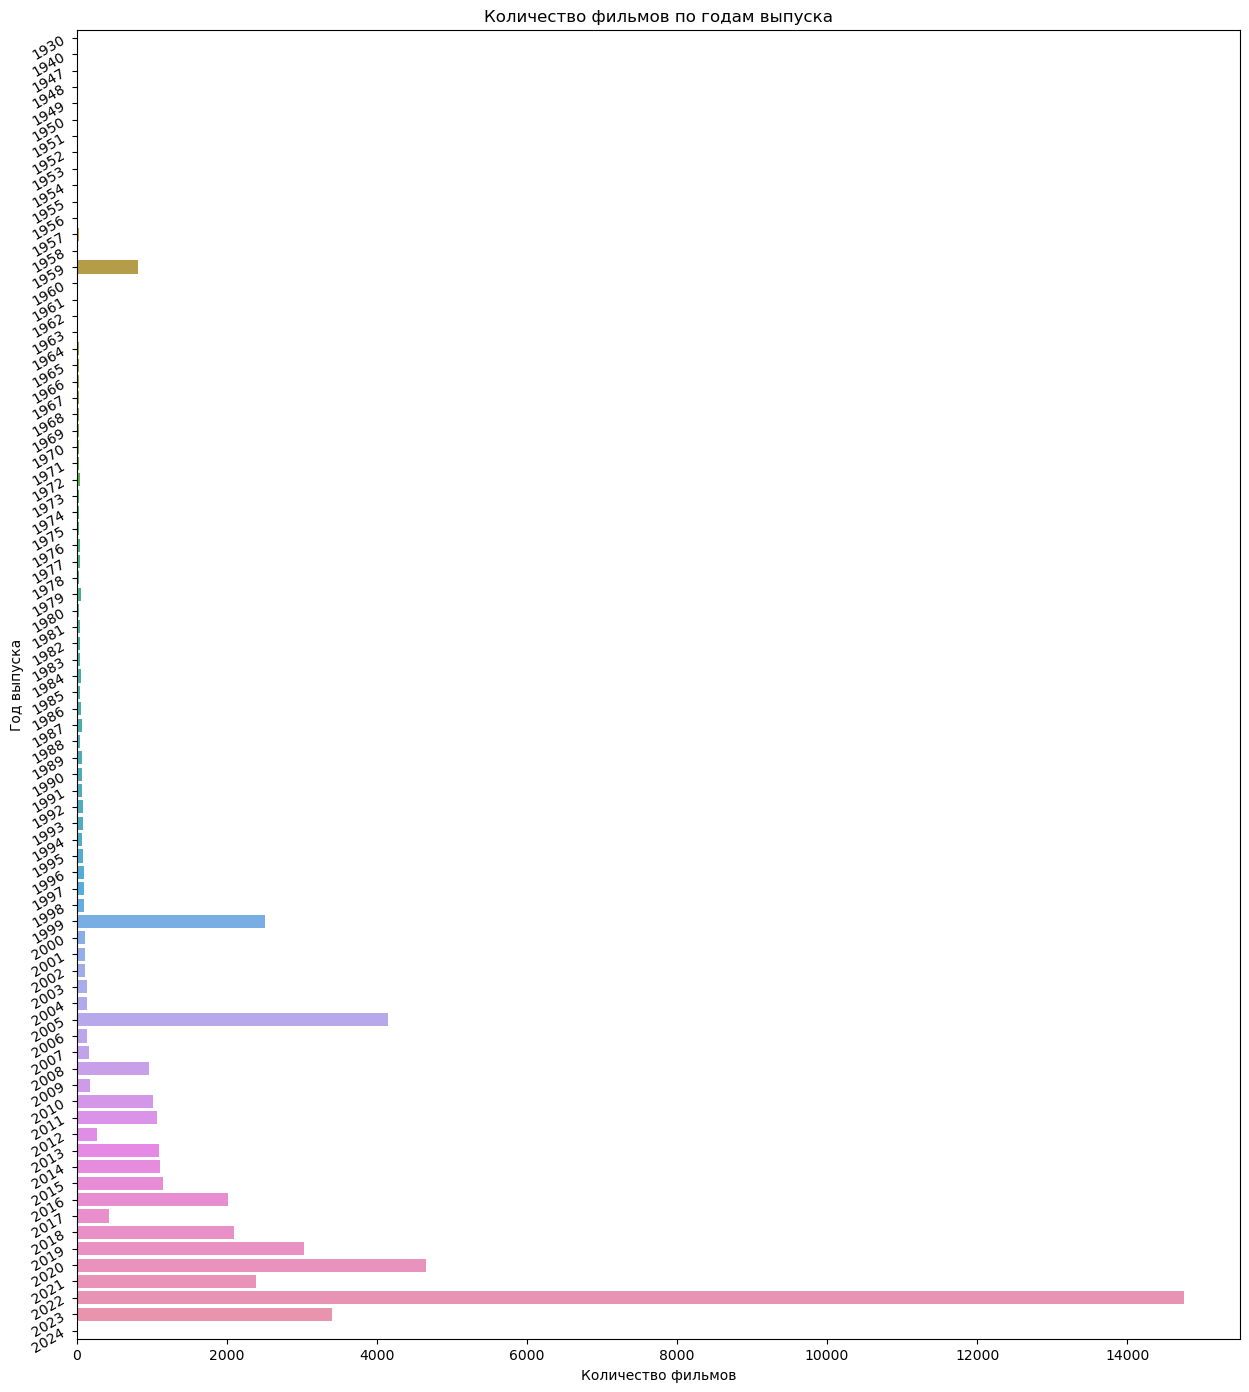

In [22]:
year_counts = final_df['release_year'].value_counts().sort_index(ascending=True)

plt.figure(figsize=(15, 17))
sns.barplot(y=year_counts.index, x=year_counts.values, orient='h')


plt.xticks(rotation=0)
plt.yticks(rotation=30)
plt.ylabel('Год выпуска')
plt.xlabel('Количество сериалов')
plt.title('Количество сериалов по годам выпуска')

plt.show();
